IMPORTING DATA


In [36]:

import os
import glob
import numpy as np
import pandas as pd

# Setup
labels = ['Bearing', 'Flywheel', 'Healthy', 'LIV', 'LOV', 'NRV', 'Piston', 'Riderbelt']
Faults = {label: idx for idx, label in enumerate(labels)}
MaxExpNo = 225

# Base path to dataset
base_path = os.path.expanduser('~/Downloads/AirCompressor_Data')

# Raw data store
raw_data = []  # list of dicts: [{'signal': ndarray, 'label': str, 'fault': int}, ...]

for label in labels:
    path = os.path.join(base_path, label, 'preprocess_Reading*.dat')
    files = sorted(glob.glob(path))
    
    if not files:
        print(f"⚠️ No files found for label: {label}")
        continue

    for file in files:
        try:
            signal = np.loadtxt(file, delimiter=',')
            raw_data.append({
                'signal': signal,
                'label': label,
                'fault': Faults[label]
            })
        except Exception as e:
            print(f"❌ Error loading {file}: {e}")

print(f"\n✅ Loaded {len(raw_data)} total files.")



✅ Loaded 1800 total files.


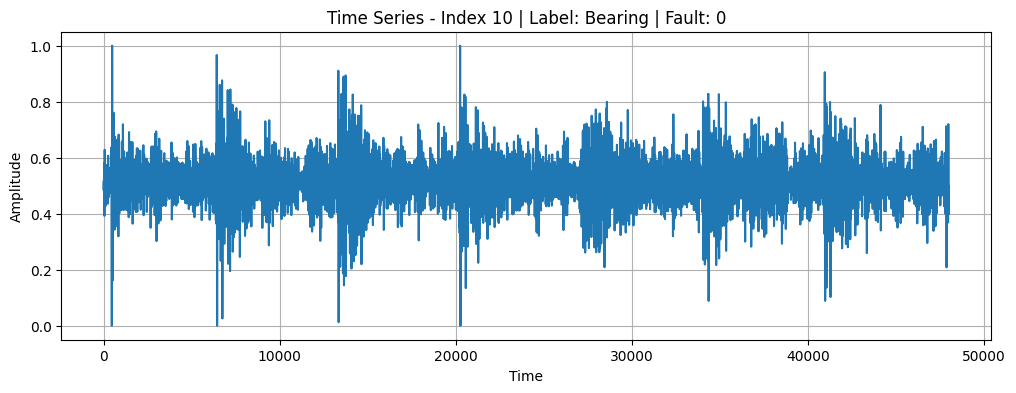

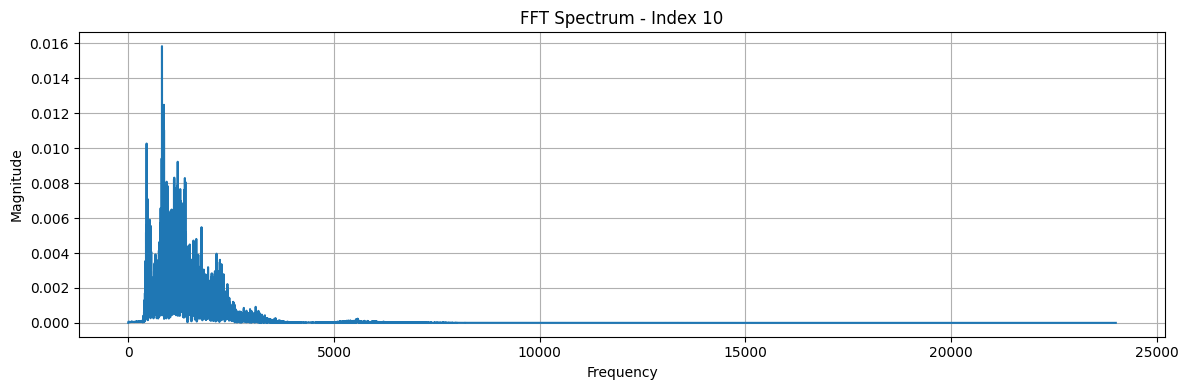

In [35]:
import matplotlib.pyplot as plt

def plot_signal(idx, show_fft=False):
    """
    Plot raw signal and optional FFT from raw_data[idx]
    """
    if idx >= len(raw_data):
        print(f"Index {idx} is out of range.")
        return
    
    signal = raw_data[idx]['signal']
    label = raw_data[idx]['label']
    fault = raw_data[idx]['fault']

    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(f"Time Series - Index {idx} | Label: {label} | Fault: {fault}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    if show_fft:
        # Compute FFT and show spectrum
        N = len(signal)
        T = 1.0 / N
        freq = np.linspace(0.0, 1.0/(2.0*T), N//2)
        X_fft = fft(signal)
        X_fft[0] = 0  # remove DC
        X_fft_magnitude = 2.0 / N * np.abs(X_fft[0:N//2])

        plt.figure(figsize=(12, 4))
        plt.plot(freq, X_fft_magnitude)
        plt.title(f"FFT Spectrum - Index {idx}")
        plt.xlabel("Frequency")
        plt.ylabel("Magnitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
plot_signal(10, show_fft=True)

Filtering signal

In [26]:
from scipy.signal import firwin, butter, filtfilt

def filter_signal(signal, Fs):
    """
    Apply fan high-pass FIR filter (400 Hz) and low-pass Butterworth (12 kHz)
    on the raw acoustic signal.
    
    Parameters:
        signal (np.ndarray): Raw time-domain signal.
        Fs (int): Sampling frequency in Hz.
    
    Returns:
        np.ndarray: Filtered signal
    """
    # ---- High-pass FIR (Fan Filter) ----
    cutoff_hp = 400  # 400 Hz fan noise removal
    nyq = Fs / 2
    fir_order = 101  # you can tune this
    hp_fir_coeffs = firwin(fir_order, cutoff_hp / nyq, pass_zero=False)
    signal_hp = filtfilt(hp_fir_coeffs, [1.0], signal)

    # ---- Low-pass Butterworth (Anti-noise Filter) ----
    cutoff_lp = 12000  # 12 kHz noise threshold
    b_lp, a_lp = butter(N=18, Wn=cutoff_lp / nyq, btype='low')
    signal_filtered = filtfilt(b_lp, a_lp, signal_hp)

    return signal_filtered



In [27]:
def clip_signal_by_std(signal, Fs):
    """
    Clip a 5-second signal into 9 overlapping 1-second segments with 50% overlap,
    and return the segment with the minimum standard deviation.
    
    Parameters:
        signal (np.ndarray): Full input signal (should be ~5 sec long)
        Fs (int): Sampling frequency in Hz

    Returns:
        np.ndarray: 1-second clipped segment with minimum standard deviation
    """
    segment_length = Fs  # 1 second = Fs samples
    stride = Fs // 2      # 50% overlap = 0.5 sec stride
    total_segments = 9

    min_std = float('inf')
    best_segment = None

    for i in range(total_segments):
        start = i * stride
        end = start + segment_length

        if end > len(signal):
            break  # avoid out-of-bound

        segment = signal[start:end]
        std = np.std(segment)

        if std < min_std:
            min_std = std
            best_segment = segment

    return best_segment

In [28]:
import numpy as np

def smooth_signal_moving_average(signal, window_size=5):
    """
    Apply a moving average filter to smooth the signal.
    
    Parameters:
        signal (np.ndarray): Input 1D signal
        window_size (int): Half-window size on each side (total window = 2*window_size + 1)
        
    Returns:
        np.ndarray: Smoothed signal
    """
    kernel_size = 2 * window_size + 1
    kernel = np.ones(kernel_size) / kernel_size
    smoothed = np.convolve(signal, kernel, mode='same')  # Keep output length same
    return smoothed


In [29]:
import numpy as np

def modified_minmax_normalization(signal, num_bins=10000, rejection_percent=0.00025):
    """
    Apply modified Min-Max normalization as described in the paper.
    Ignores top/bottom 0.025% of values while computing min/max.
    
    Parameters:
        signal (np.ndarray): Input 1D signal
        num_bins (int): Number of histogram bins (default: 10,000)
        rejection_percent (float): Fraction of data to reject from both ends (default: 0.025%)
        
    Returns:
        np.ndarray: Normalized signal between 0 and 1
    """

    N = len(signal)
    total_reject = int(rejection_percent * N)

    # Build histogram
    hist_counts, bin_edges = np.histogram(signal, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Cumulative count
    cum_counts = np.cumsum(hist_counts)

    # Find mod_min: first bin index after rejecting lower values
    lower_idx = np.searchsorted(cum_counts, total_reject)
    mod_min = bin_centers[lower_idx]

    # Find mod_max: first bin index from top after rejecting upper values
    upper_idx = np.searchsorted(cum_counts, N - total_reject)
    mod_max = bin_centers[upper_idx]

    # Apply modified Min-Max normalization
    clipped = np.clip(signal, mod_min, mod_max)
    normalized = (clipped - mod_min) / (mod_max - mod_min)

    return normalized

In [39]:
for entry in raw_data:
    Fs = 48000
    entry['original_signal'] = entry['signal'].copy()  # store raw

    signal = entry['signal']
    signal = filter_signal(signal, Fs)                             # Step A
    signal = clip_signal_by_std(signal, Fs)                        # Step B
    signal = smooth_signal_moving_average(signal, window_size=5)  # Step C
    signal = modified_minmax_normalization(signal)                # Step D

    entry['signal'] = signal  # store preprocessed


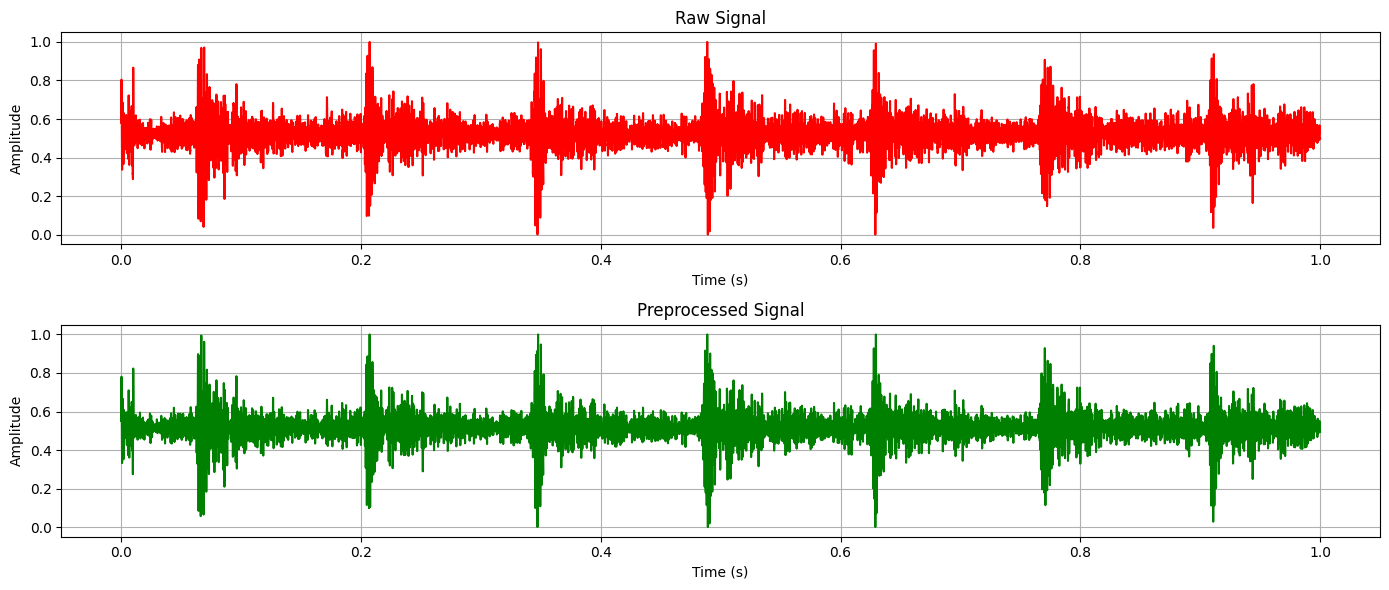

In [40]:
import matplotlib.pyplot as plt
import numpy as np

idx = 0  # or any valid index
raw = raw_data[idx]['original_signal']
processed = raw_data[idx]['signal']
Fs = 48000

t_raw = np.arange(len(raw)) / Fs
t_proc = np.arange(len(processed)) / Fs

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(t_raw, raw, color='red')
plt.title('Raw Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_proc, processed, color='green')
plt.title('Preprocessed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()


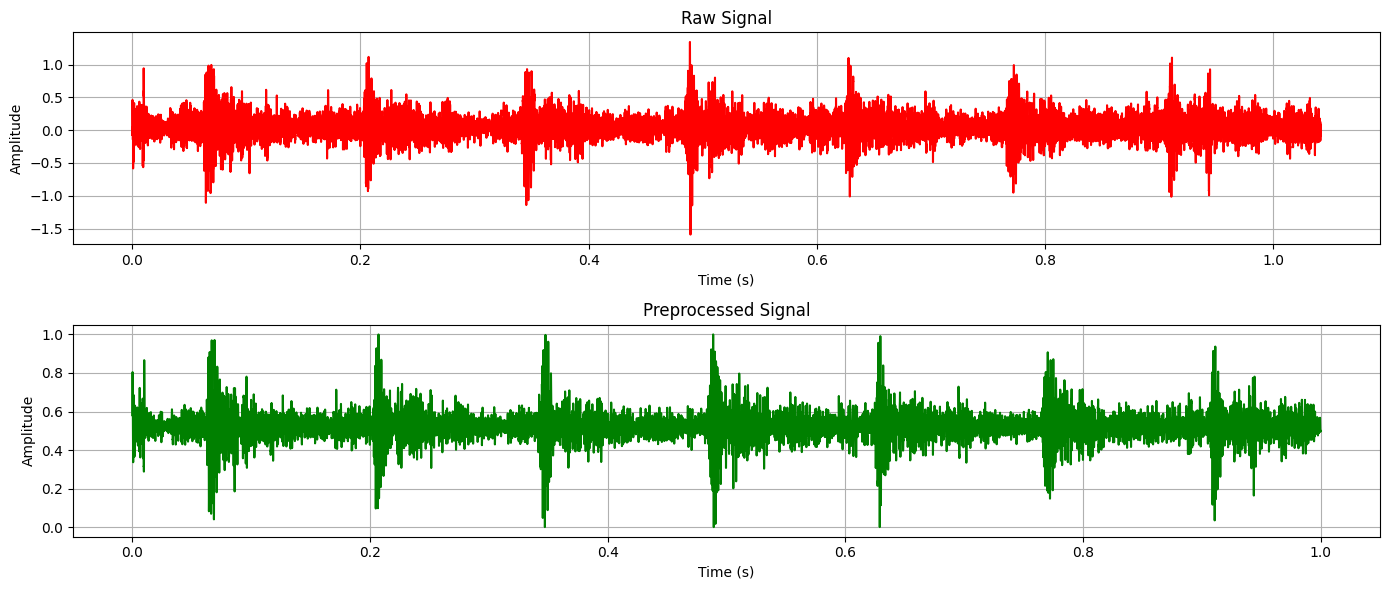

In [38]:
import matplotlib.pyplot as plt
import numpy as np

idx = 0  # or any valid index
raw = raw_data[idx]['original_signal']
processed = raw_data[idx]['signal']
Fs = 48000

t_raw = np.arange(len(raw)) / Fs
t_proc = np.arange(len(processed)) / Fs

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(t_raw, raw, color='red')
plt.title('Raw Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_proc, processed, color='green')
plt.title('Preprocessed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.fftpack import fft

# --- Feature Extraction Functions ---

def PrimaryFeatureExtractor(X):
    rms = np.sqrt(np.mean(np.square(X)))
    CrestFactor = np.abs(X).max() / rms
    ShapeFactor = rms / np.mean(np.abs(X))
    return [[
        np.mean(np.abs(X)),
        np.min(X),
        np.max(X),
        np.std(X),
        rms,
        skew(X),
        kurtosis(X),
        CrestFactor,
        ShapeFactor
    ]]

def FFT_BasedFeatures(X, NBins=100):
    N = len(X)
    T = 1.0 / N
    FreqList = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
    X_fft = fft(X)
    X_fft[0] = 0
    X_fft_magnitude = 2.0 / N * np.abs(X_fft[0:N // 2])

    BinCounts = (N // 2) // NBins
    SpecEnergy = []
    labels = []

    for i in range(NBins):
        SpecEnergy.append(X_fft_magnitude[i * BinCounts:(i + 1) * BinCounts].sum())
        labels.append(f'FFT{i + 1}')

    return SpecEnergy, labels

# --- Data Processing ---

feature_rows = []
data_columns_FFT_Features = None  # to be initialized during first FFT extraction

for idx, entry in enumerate(raw_data):
    try:
        X = entry['signal']
        
        # Extract statistical and FFT features
        StatFeatures = PrimaryFeatureExtractor(X)[0]
        FFT_Features, data_columns_FFT_Features = FFT_BasedFeatures(X)

        # Merge all features + fault label
        row = StatFeatures + FFT_Features + [entry['fault']]
        feature_rows.append(row)

        if idx % 10 == 0:
            print(f"✅ Processed {idx}/{len(raw_data)} entries")

    except Exception as e:
        print(f"❌ Error extracting features for index {idx}: {e}")

# --- Build DataFrame using original names ---

data_columns_PrimaryStatFeatures = [
    'Mean', 'Min', 'Max', 'StdDv', 'RMS', 'Skewness',
    'Kurtosis', 'CrestFactor', 'ShapeFactor'
]
data_columns_Target = ['Fault']
data_columns = data_columns_PrimaryStatFeatures + data_columns_FFT_Features + data_columns_Target

# Create final DataFrame
data = pd.DataFrame(feature_rows, columns=data_columns)

# Split into inputs and labels
input_data = data.drop(columns=['Fault'])
target_data = pd.DataFrame(data['Fault'], columns=['Fault'], dtype=int)

print("\n✅ Feature extraction and DataFrame construction complete.")
print(f"📊 input_data shape: {input_data.shape}")
print(f"🎯 target_data shape: {target_data.shape}")


✅ Processed 0/1800 entries
✅ Processed 10/1800 entries
✅ Processed 20/1800 entries
✅ Processed 30/1800 entries
✅ Processed 40/1800 entries
✅ Processed 50/1800 entries
✅ Processed 60/1800 entries
✅ Processed 70/1800 entries
✅ Processed 80/1800 entries
✅ Processed 90/1800 entries
✅ Processed 100/1800 entries
✅ Processed 110/1800 entries
✅ Processed 120/1800 entries
✅ Processed 130/1800 entries
✅ Processed 140/1800 entries
✅ Processed 150/1800 entries
✅ Processed 160/1800 entries
✅ Processed 170/1800 entries
✅ Processed 180/1800 entries
✅ Processed 190/1800 entries
✅ Processed 200/1800 entries
✅ Processed 210/1800 entries
✅ Processed 220/1800 entries
✅ Processed 230/1800 entries
✅ Processed 240/1800 entries
✅ Processed 250/1800 entries
✅ Processed 260/1800 entries
✅ Processed 270/1800 entries
✅ Processed 280/1800 entries
✅ Processed 290/1800 entries
✅ Processed 300/1800 entries
✅ Processed 310/1800 entries
✅ Processed 320/1800 entries
✅ Processed 330/1800 entries
✅ Processed 340/1800 entr

In [3]:
input_data

,Mean,Min,Max,StdDv,RMS,Skewness,Kurtosis,CrestFactor,ShapeFactor,FFT1,...,FFT91,FFT92,FFT93,FFT94,FFT95,FFT96,FFT97,FFT98,FFT99,FFT100
0,0.140067,-1.5920,1.3448,0.186773,0.192985,-0.186858,4.518489,8.249357,1.377799,0.032111,...,0.000141,0.000132,0.000123,0.000114,0.000106,0.000099,0.000093,0.000087,0.000084,0.000082
1,0.187374,-1.4158,1.3472,0.202243,0.239738,-0.297777,3.182940,5.905620,1.279463,0.035926,...,0.001102,0.001102,0.001103,0.001103,0.001103,0.001103,0.001104,0.001104,0.001103,0.001104
2,0.201925,-1.3502,1.1123,0.230012,0.259409,-0.205917,1.754806,5.204907,1.284679,0.038505,...,0.001468,0.001472,0.001475,0.001477,0.001480,0.001482,0.001483,0.001485,0.001485,0.001486
3,0.177199,-1.3254,1.1532,0.223281,0.235517,-0.205812,2.146448,5.627623,1.329111,0.063200,...,0.000268,0.000253,0.000239,0.000224,0.000211,0.000199,0.000189,0.000179,0.000174,0.000171
4,0.182402,-1.2071,1.2910,0.237785,0.239437,-0.075352,1.286465,5.391815,1.312691,0.155544,...,0.003041,0.003039,0.003037,0.003035,0.003035,0.003033,0.003033,0.003033,0.003032,0.003031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.143902,-1.3802,1.5637,0.194700,0.194728,0.025085,2.808758,8.030176,1.353194,0.029575,...,0.000227,0.000229,0.000230,0.000231,0.000231,0.000232,0.000233,0.000233,0.000233,0.000234
1796,0.137908,-1.4787,1.4960,0.180747,0.187902,-0.053696,4.104418,7.961604,1.362513,0.025515,...,0.000054,0.000049,0.000045,0.000040,0.000035,0.000031,0.000027,0.000024,0.000021,0.000020
1797,0.131200,-1.2317,1.5648,0.178472,0.181081,0.075692,4.157256,8.641426,1.380187,0.021799,...,0.000821,0.000821,0.000821,0.000821,0.000821,0.000821,0.000821,0.000821,0.000821,0.000821
1798,0.131577,-1.3973,1.3526,0.178887,0.180757,0.011308,3.914086,7.730254,1.373775,0.039722,...,0.001398,0.001396,0.001395,0.001393,0.001391,0.001390,0.001389,0.001388,0.001388,0.001388


In [6]:
from sklearn import preprocessing
normalization_status='RobustScaler'   
''' Choices:
                                        1. Normalization
                                        2. StandardScaler
                                        3. MinMaxScaler
                                        4. RobustScaler
                                        5. Normalizer
                                        6. WithoutNormalization   '''
input_data_columns=data_columns_PrimaryStatFeatures+data_columns_FFT_Features

if (normalization_status=='Normalization'):
    data_array=preprocessing.normalize(input_data,norm='l2',axis=0)
    input_data=pd.DataFrame(data_array,columns=input_data_columns)
elif (normalization_status=='StandardScaler'):
    scaler = preprocessing.StandardScaler()
    scaled_df = scaler.fit_transform(input_data)
    input_data = pd.DataFrame(scaled_df, columns=input_data_columns)
elif (normalization_status=='MinMaxScaler'):
    scaler = preprocessing.MinMaxScaler()
    scaled_df = scaler.fit_transform(input_data)
    input_data = pd.DataFrame(scaled_df, columns=input_data_columns)
elif (normalization_status=='RobustScaler'):
    scaler = preprocessing.RobustScaler()
    scaled_df = scaler.fit_transform(input_data)
    input_data = pd.DataFrame(scaled_df, columns=input_data_columns)
elif (normalization_status=='Normalizer'):
    scaler = preprocessing.Normalizer()
    scaled_df = scaler.fit_transform(input_data)
    input_data = pd.DataFrame(scaled_df, columns=input_data_columns)
elif (normalization_status=='WithoutNormalization'):
    print ('No normalization is required')

target_data=pd.DataFrame(data['Fault'],columns=['Fault'],dtype=int)